In [1]:
import os
import time
import numpy
import pandas as pd
import numpy as np
import cvxpy as cp
from datetime import timedelta
import job_config as jc
import model_config as mc
# from Functions.doc_functions import *
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['Arial Unicode MS']#用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False#用来正常显示负号
import matplotlib
#matplotlib.use('Agg')  # 不显示图片



In [2]:
score = pd.read_pickle('score_2model.pkl')

In [3]:
score

,security_code,trade_date,MLP_5,Xgb_5,MLP_10,Xgb_10,MLP_22,Xgb_22
0,000001,2017-01-03,-2.881044,-0.005443,-1.742311,-0.003917,-5.293172,-0.016267
1,000002,2017-01-03,1.655878,0.004627,5.327276,0.017158,7.235570,0.015681
2,000005,2017-01-03,4.474424,0.003962,0.844034,0.002680,-0.647187,-0.000730
3,000006,2017-01-03,-3.763432,-0.003199,-2.196741,-0.000438,-11.111130,-0.023333
4,000007,2017-01-03,-2.047803,-0.002653,3.363665,-0.005314,8.787384,-0.029392
...,...,...,...,...,...,...,...,...
3457,688787,2024-04-30,-0.136089,-0.000494,0.893230,0.001788,2.845930,-0.004876
3458,688798,2024-04-30,0.160931,-0.000327,3.519590,0.001672,3.729131,0.001065
3459,688800,2024-04-30,1.809813,0.000619,1.854774,0.000233,-3.325960,-0.012592
3460,688819,2024-04-30,1.550875,0.002729,4.517440,0.004470,5.833215,0.000998


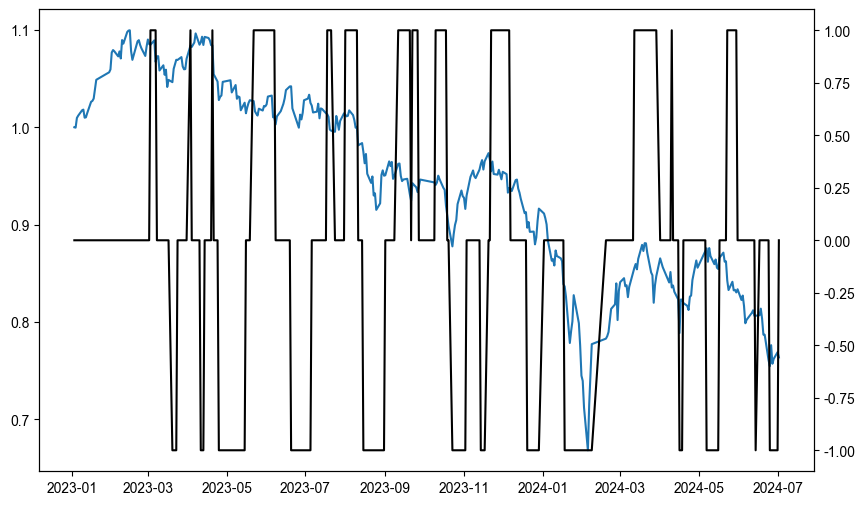

In [37]:
index_price = pd.read_pickle(os.path.join(jc.database_path, jc.index_price))
index_price = index_price.loc[index_price.security_code == '000852']


index_price['trade_date'] = pd.to_datetime(index_price['trade_date'])
index_price = index_price[(index_price['trade_date'] >= '2023-01-01') & (index_price['trade_date'] <= '2024-09-01')]
index_price['close'] = index_price['close']/index_price['close'].iloc[0]

index_price['vix'] = index_price['close'].rolling(20).std()

rolling_window = 20
index_price['boll_upper'] = index_price['vix'].rolling(rolling_window).mean() + 1 * index_price['vix'].rolling(rolling_window).std()
index_price['boll_lower'] = index_price['vix'].rolling(rolling_window).mean() - 1 * index_price['vix'].rolling(rolling_window).std()
index_price['boll_mean'] = index_price['vix'].rolling(rolling_window).mean()


# if vix > boll_upper, short, if vix < boll_lower, long
index_price['signal'] = 0
index_price.loc[index_price['vix'] > index_price['boll_upper'], 'signal'] = -1
index_price.loc[index_price['vix'] < index_price['boll_lower'], 'signal'] = 1

index_price['rolling_return'] = index_price['close'].pct_change().rolling(rolling_window).sum()
# index_price['return_signal'] = 0
# index_price.loc[index_price['rolling_return'] >= 0, 'return_signal'] = 1
# index_price.loc[index_price['rolling_return'] < 0, 'return_signal'] = -1

# index_price['signal'] = index_price['signal'] * index_price['return_signal']


plt.figure(figsize=(10, 6))

plt.plot(index_price['trade_date'],index_price['close'].reset_index(drop=True))
plt.twinx()
# # plt.plot(index_price['trade_date'],index_price['close'].rolling(20).std().reset_index(drop=True), 'r')
# plt.plot(index_price['trade_date'],index_price['boll_upper'].reset_index(drop=True), 'r')
# plt.plot(index_price['trade_date'],index_price['boll_lower'].reset_index(drop=True), 'g')
# #plt.plot(index_price['trade_date'],index_price['boll_mean'].reset_index(drop=True), 'y')

# plt.plot(index_price['trade_date'],index_price['vix'].reset_index(drop=True), 'b')

#plt.plot(index_price['trade_date'],index_price['rolling_return'].reset_index(drop=True), 'k')

plt.plot(index_price['trade_date'],index_price['signal'].reset_index(drop=True), 'k')


In [ ]:
score

In [33]:
df_index = pd.read_csv('df_index_sample.csv')
df_index

,Unnamed: 0,barra_beta,barra_momentum,barra_size,barra_earnyild,barra_resvol,barra_growth,barra_btop,barra_leverage,barra_liquidty,...,barra_beta_std,barra_momentum_std,barra_size_std,barra_earnyild_std,barra_resvol_std,barra_growth_std,barra_btop_std,barra_leverage_std,barra_liquidty_std,barra_sizenl_std
0,2014-10-31,0.595703,0.842287,-1.950275,-1.352675,0.640477,0.130487,-1.345543,-0.938371,1.061115,...,1.002262,1.006328,0.570747,0.722297,1.030528,0.947569,0.663367,0.862742,0.901717,0.506006
1,2014-11-03,0.589566,0.855226,-1.925494,-1.357257,0.635487,0.131260,-1.365132,-0.935893,1.065539,...,1.004580,1.000866,0.571985,0.723319,1.032435,0.947439,0.661375,0.862312,0.905713,0.508084
2,2014-11-04,0.599669,0.878342,-1.935691,-1.359251,0.624866,0.133252,-1.377789,-0.940537,1.060219,...,1.005533,0.990662,0.567782,0.727348,1.034080,0.947370,0.668986,0.862443,0.907677,0.506487
3,2014-11-05,0.588306,0.891538,-1.928624,-1.355905,0.627549,0.134007,-1.373322,-0.938441,1.062910,...,1.007936,0.982630,0.566780,0.725545,1.032231,0.947184,0.665824,0.862530,0.907554,0.506572
4,2014-11-06,0.588712,0.893112,-1.924135,-1.354021,0.632496,0.133846,-1.371628,-0.935460,1.065985,...,1.007541,0.977322,0.569078,0.725347,1.030918,0.947508,0.665241,0.862342,0.907898,0.508463
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2347,2024-06-26,1.194607,-0.396468,-1.624279,-0.613659,-0.870290,0.141243,-0.263276,-0.470355,0.321917,...,1.033729,1.152458,0.490683,1.029596,0.883459,0.884609,1.047413,0.988528,0.889275,0.497792
2348,2024-06-27,1.234998,-0.407761,-1.645778,-0.595577,-0.861190,0.143748,-0.245948,-0.473650,0.318747,...,1.029944,1.153091,0.490689,1.035022,0.882573,0.884157,1.049447,0.988680,0.887092,0.495250
2349,2024-06-28,1.271221,-0.380620,-1.660468,-0.586323,-0.826016,0.165916,-0.264358,-0.494160,0.389305,...,1.036718,1.142554,0.429468,1.031724,0.922512,0.872133,1.038038,0.980561,0.923339,0.416237
2350,2024-07-01,1.283806,-0.370151,-1.654715,-0.591254,-0.806463,0.168064,-0.270513,-0.499743,0.388573,...,1.030055,1.133716,0.430749,1.026650,0.925681,0.870145,1.036806,0.980193,0.921336,0.420889


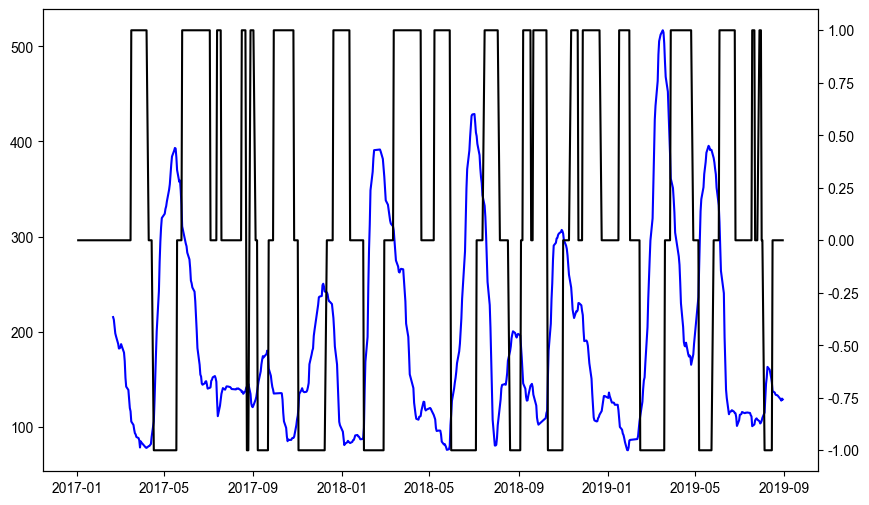

In [19]:

plt.figure(figsize=(10, 6))
# # plt.plot(index_price['trade_date'],index_price['close'].rolling(20).std().reset_index(drop=True), 'r')
# plt.plot(index_price['trade_date'],index_price['boll_upper'].reset_index(drop=True), 'r')
# plt.plot(index_price['trade_date'],index_price['boll_lower'].reset_index(drop=True), 'g')
# #plt.plot(index_price['trade_date'],index_price['boll_mean'].reset_index(drop=True), 'y')

plt.plot(index_price['trade_date'],index_price['vix'].reset_index(drop=True), 'b')
plt.twinx()

plt.plot(index_price['trade_date'],index_price['signal'].reset_index(drop=True), 'k')

In [6]:
index_price

,security_code,trade_date,close,open,low,high,vix,boll_upper,boll_lower,boll_mean,signal
2208,000852,2015-01-05,6049.7870,6025.7470,5948.2720,6052.4420,NaN,NaN,NaN,NaN,0
2209,000852,2015-01-06,6172.3920,6021.4490,5986.4010,6172.6440,NaN,NaN,NaN,NaN,0
1966,000852,2015-01-07,6166.7690,6161.4820,6118.1400,6171.1460,NaN,NaN,NaN,NaN,0
1967,000852,2015-01-08,6164.1110,6161.5530,6126.9660,6211.4600,NaN,NaN,NaN,NaN,0
1968,000852,2015-01-09,6128.0120,6148.1090,6128.0120,6214.2880,NaN,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...
4347,000852,2018-08-27,5229.3611,5121.1865,5121.1865,5229.3611,198.494564,224.901087,69.850159,147.375623,0
4348,000852,2018-08-28,5233.5027,5229.6179,5212.3881,5244.1530,195.575450,226.686707,79.605042,153.145874,0
4349,000852,2018-08-29,5203.7117,5229.0711,5190.1372,5229.1056,193.777608,226.046404,91.530837,158.788620,0
4350,000852,2018-08-30,5114.2663,5193.6898,5112.1792,5206.9536,196.048778,224.590831,103.752416,164.171623,0
